In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
from PIL import Image
from IPython.display import display
sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from catalogue import load_catalogue

In [2]:
# Set the output directories here
outdirs_1 = [
    ('outdir_b_all_cauchy', 'log_evidence'),
    ('outdir_b_all_gaussian', 'log_evidence'),
    ('outdir_b_all_equad50', 'log_evidence'),
    ('outdir_b_all_eflq50', 'log_evidence'),
    ('outdir_a_all', 'aic'),
]

outdirs_2 = [
    ('outdir_b_img_cauchy', 'log_evidence'),
    ('outdir_b_img_gaussian', 'log_evidence'),
    ('outdir_b_img_equad50', 'log_evidence'),
    ('outdir_b_img_eflq50', 'log_evidence'),
    ('outdir_a_img', 'aic'),
]

In [6]:
def results_from_outdirs(outdirs, msp=False, ten_points=False):
    results, param_ests = [], []
    for outdir, var in outdirs:
        with open(f'../output/results_param_estimates_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
            param_est = json.load(f)
        with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
            result = pd.DataFrame(json.load(f)).T
        with open(f'../output/results_good_fit_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
            good_fit_results = pd.DataFrame(json.load(f)).T  # table of true/false
            # transform good_fit_results to array of bools
            good_fit_results = good_fit_results.applymap(lambda x: x == 'True')
        
        # set result to NaN if the fit is not good
        result = result.where(good_fit_results)
        
        # best_fitting column
        result['best_fitting'] = result.idxmax(axis=1) if var == 'log_evidence' else result.idxmin(axis=1)
        
        # if all columns are NaN, set best_fitting to '(Unclassified)'
        result['best_fitting'] = result['best_fitting'].fillna('(Unclassified)')
            
        print(f'{outdir}:')
        catalogue = load_catalogue(outdirs[0][0])
        print(f' - Number of pulsars in the catalogue: {len(catalogue)}')
        str1, str2 = '', ''
        for n in range(4, 7):
            str1 += f', {n}'
            str2 += f', {len(catalogue.at_least_n_points(n))}'
        str1 = str1[2:]
        str2 = str2[2:]
        print(f' - Number of pulsars with at least {str1} measurements: {str2}')
        print(f' - Number of pulsars reaching fitting requirements: {len(result)}')
        if msp or ten_points:
            subset = catalogue.MSPs if msp else catalogue.at_least_n_points(10)
            subset = [jname for jname in subset if jname in result.index]
            result = result.loc[subset]
        results.append(result)
        param_ests.append(param_est)
    return results, param_ests

In [7]:
model_names = ['simple_power_law', 'broken_power_law', 'log_parabolic_spectrum', 'high_frequency_cut_off_power_law', 'low_frequency_turn_over_power_law', 'double_turn_over_spectrum', '(Unclassified)']
model_names_c = ['simple power law', 'broken power law', 'log-parabolic spectrum', 'high-frequency cut-off power law', 'low-frequency turn-over power law', 'double turn-over spectrum', '(Unclassified)']
model_names_b = ['simple\npower law', 'broken\npower law', 'log-parabolic\nspectrum', 'high-frequency\ncut-off power law', 'low-frequency\nturn-over power law', 'double\nturn-over spectrum', '(Unclassified)']
model_name_cap = lambda x: np.array([model_names_c[model_names.index(m)] for m in x])
model_name_br = lambda x: np.array([model_names_c[model_names.index(m)] for m in x])
def bar_chart(outdirs, save_path=None, msp=False, ten_points=False):
    results, _ = results_from_outdirs(outdirs, msp, ten_points)
    rx, ry = [], []
    r_total = []
    for r in results:
        rx_i = r['best_fitting'].value_counts().index.to_numpy()
        ry_i = r['best_fitting'].value_counts().to_numpy()
        rx.append(rx_i)
        ry.append(ry_i)
        r_total.append(len(r))
    
    # move unclassified to the end
    if '(Unclassified)' in rx[0]:
        idx = np.where(rx[0] == '(Unclassified)')[0][0]
        rx[0] = np.concatenate([rx[0][:idx], rx[0][idx+1:], [rx[0][idx]]])
        ry[0] = np.concatenate([ry[0][:idx], ry[0][idx+1:], [ry[0][idx]]])
    
    # sort by rx[0]
    N = len(rx)
    # add the missing model names to rx[0]
    rx_0_missing = [model for model in model_names if model not in rx[0]]
    rx[0] = np.concatenate([rx[0], rx_0_missing])
    ry[0] = np.concatenate([ry[0], np.zeros(len(rx_0_missing))])
    for i in range(1, N):
        # add the missing model names to rest of the rx
        for j, model in enumerate(rx[0]):
            if model not in rx[i]:
                rx[i] = np.insert(rx[i], j, model)
                ry[i] = np.insert(ry[i], j, 0)
                
        rx[i], ry[i] = zip(*sorted(zip(rx[i], ry[i]), key=lambda x: rx[0].tolist().index(x[0])))
    
    df_dict = {
        'Model': model_name_cap(rx[0]).tolist(),
    }
    for i, (x, y, total) in enumerate(zip(rx, ry, r_total)):
        df_dict[outdirs[i][0]] = [f'{v:.0f} / {total} ({v/total*100:.1f}%)' for v in y]
    display(pd.DataFrame(df_dict))
    
    r_bf_dict = {}
    r_bf_gt5_dict = {}
    r_bf_total = {}
    for r, outdir_var in zip(results, outdirs):
        outdir, var = outdir_var
        if var == 'aic':
            continue
        r = r[r['best_fitting'] != '(Unclassified)']  # Remove unclassified pulsars
        r_bf = r.drop(columns='best_fitting').sub(r['simple_power_law'], axis=0).drop(columns='simple_power_law')
        r_bf_dict[outdir] = r_bf
        r_bf_gt5_dict[outdir] = (r_bf > 3).sum()
        r_bf_total[outdir] = len(r)
        
    # sort by the first method
    r_bf_gt5 = pd.DataFrame(r_bf_gt5_dict)
    
    r_bf_gt5.loc['(Any ln BF > 3)'] = [(r_bf > 3).any(axis=1).sum() for r_bf in r_bf_dict.values()]
    r_bf_gt5.loc['(All ln BF < -3)'] = [(r_bf < -3).all(axis=1).sum() for r_bf in r_bf_dict.values()]
    
    # change the values to {} / {} = {}% format
    for col in r_bf_gt5.columns:
        r_bf_gt5[col] = [f'{r_bf_gt5[col][i]:.0f} / {r_bf_total[col]} ({r_bf_gt5[col][i]/r_bf_total[col]*100:.1f}%)' for i in r_bf_gt5.index]
    display(r_bf_gt5)
    
    fig, ax = plt.subplots(figsize=(24, 4))
    
    bar_width = 1 / (N + 1)
    bar_positions = np.arange(len(rx[0]))
    
    colors = sns.color_palette('icefire', N)
    for i, (x, y, total) in enumerate(zip(rx, ry, r_total)):
        ax.bar(bar_positions + bar_width * (i - N / 2), y, bar_width, label=outdirs[i][0], color=colors[i])
        labels = [f'{v:.0f}\n{v/total*100:.1f}%' for v in y]
        for j, label in enumerate(labels):
            ax.text(j + bar_width * (i - N / 2), y[j] + 1, label, ha='center', va='bottom', fontsize=9)
    
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(model_name_br(rx[0]))
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

outdir_b_all_cauchy:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_gaussian:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_equad50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 868
outdir_b_all_eflq50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_a_all:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882


,Model,outdir_b_all_cauchy,outdir_b_all_gaussian,outdir_b_all_equad50,outdir_b_all_eflq50,outdir_a_all
0,broken power law,299 / 882 (33.9%),542 / 882 (61.5%),248 / 868 (28.6%),539 / 882 (61.1%),292 / 882 (33.1%)
1,simple power law,257 / 882 (29.1%),119 / 882 (13.5%),307 / 868 (35.4%),119 / 882 (13.5%),234 / 882 (26.5%)
2,low-frequency turn-over power law,208 / 882 (23.6%),96 / 882 (10.9%),213 / 868 (24.5%),98 / 882 (11.1%),61 / 882 (6.9%)
3,double turn-over spectrum,56 / 882 (6.3%),49 / 882 (5.6%),34 / 868 (3.9%),48 / 882 (5.4%),28 / 882 (3.2%)
4,high-frequency cut-off power law,27 / 882 (3.1%),33 / 882 (3.7%),23 / 868 (2.6%),35 / 882 (4.0%),84 / 882 (9.5%)
5,log-parabolic spectrum,27 / 882 (3.1%),26 / 882 (2.9%),27 / 868 (3.1%),26 / 882 (2.9%),168 / 882 (19.0%)
6,(Unclassified),8 / 882 (0.9%),17 / 882 (1.9%),16 / 868 (1.8%),17 / 882 (1.9%),15 / 882 (1.7%)


,outdir_b_all_cauchy,outdir_b_all_gaussian,outdir_b_all_equad50,outdir_b_all_eflq50
broken_power_law,297 / 874 (34.0%),603 / 865 (69.7%),206 / 852 (24.2%),603 / 865 (69.7%)
double_turn_over_spectrum,211 / 874 (24.1%),411 / 865 (47.5%),143 / 852 (16.8%),407 / 865 (47.1%)
high_frequency_cut_off_power_law,142 / 874 (16.2%),415 / 865 (48.0%),86 / 852 (10.1%),417 / 865 (48.2%)
log_parabolic_spectrum,213 / 874 (24.4%),499 / 865 (57.7%),165 / 852 (19.4%),497 / 865 (57.5%)
low_frequency_turn_over_power_law,264 / 874 (30.2%),452 / 865 (52.3%),204 / 852 (23.9%),449 / 865 (51.9%)
(Any ln BF > 3),331 / 874 (37.9%),630 / 865 (72.8%),236 / 852 (27.7%),629 / 865 (72.7%)
(All ln BF < -3),0 / 874 (0.0%),0 / 865 (0.0%),0 / 852 (0.0%),0 / 865 (0.0%)


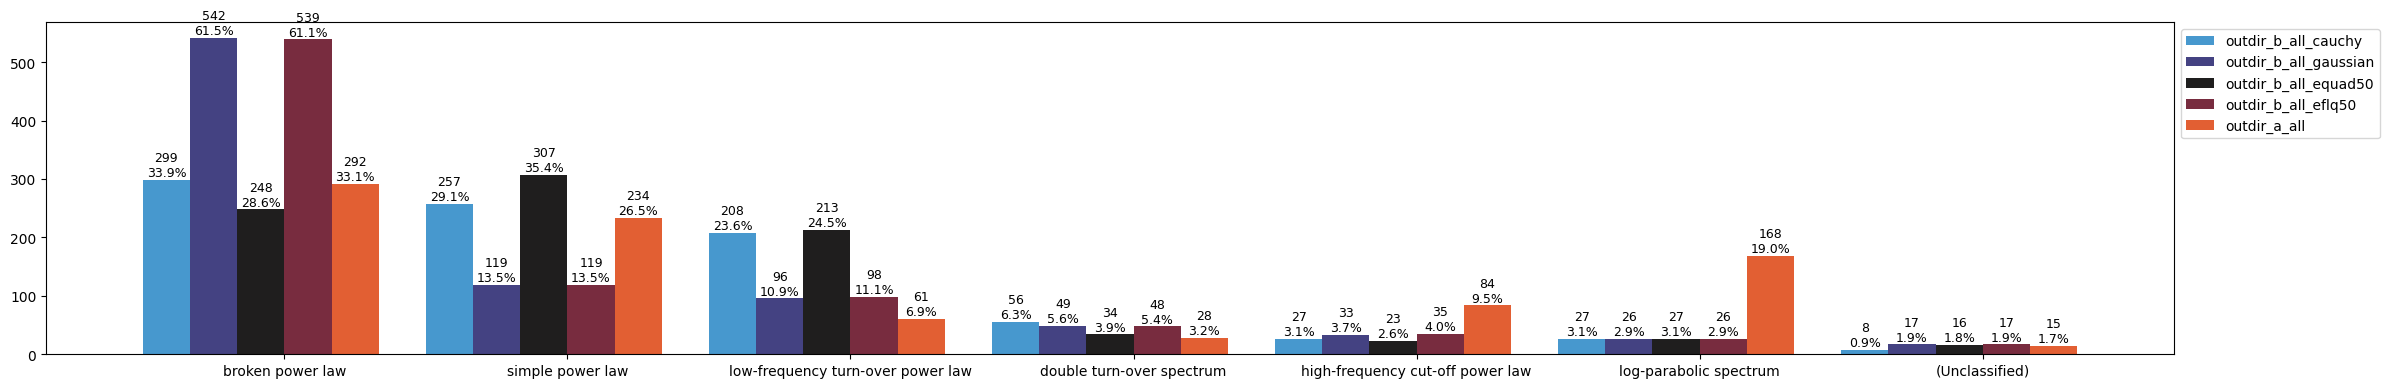

In [8]:
bar_chart(outdirs_1, 'bar_chart_1.png')

outdir_b_img_cauchy:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_b_img_gaussian:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_b_img_equad50:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_b_img_eflq50:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36
outdir_a_img:
 - Number of pulsars in the catalogue: 425
 - Number of pulsars with at least 4, 5, 6 measurements: 36, 21, 14
 - Number of pulsars reaching fitting requirements: 36


,Model,outdir_b_img_cauchy,outdir_b_img_gaussian,outdir_b_img_equad50,outdir_b_img_eflq50,outdir_a_img
0,simple power law,12 / 36 (33.3%),3 / 36 (8.3%),15 / 36 (41.7%),3 / 36 (8.3%),18 / 36 (50.0%)
1,low-frequency turn-over power law,12 / 36 (33.3%),12 / 36 (33.3%),13 / 36 (36.1%),12 / 36 (33.3%),1 / 36 (2.8%)
2,broken power law,11 / 36 (30.6%),19 / 36 (52.8%),8 / 36 (22.2%),19 / 36 (52.8%),4 / 36 (11.1%)
3,double turn-over spectrum,1 / 36 (2.8%),1 / 36 (2.8%),0 / 36 (0.0%),1 / 36 (2.8%),0 / 36 (0.0%)
4,log-parabolic spectrum,0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%),9 / 36 (25.0%)
5,high-frequency cut-off power law,0 / 36 (0.0%),1 / 36 (2.8%),0 / 36 (0.0%),1 / 36 (2.8%),3 / 36 (8.3%)
6,(Unclassified),0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%),1 / 36 (2.8%)


,outdir_b_img_cauchy,outdir_b_img_gaussian,outdir_b_img_equad50,outdir_b_img_eflq50
broken_power_law,8 / 36 (22.2%),24 / 36 (66.7%),3 / 36 (8.3%),24 / 36 (66.7%)
double_turn_over_spectrum,4 / 36 (11.1%),11 / 36 (30.6%),2 / 36 (5.6%),11 / 36 (30.6%)
high_frequency_cut_off_power_law,1 / 36 (2.8%),13 / 36 (36.1%),1 / 36 (2.8%),13 / 36 (36.1%)
log_parabolic_spectrum,5 / 36 (13.9%),20 / 36 (55.6%),2 / 36 (5.6%),20 / 36 (55.6%)
low_frequency_turn_over_power_law,9 / 36 (25.0%),20 / 36 (55.6%),5 / 36 (13.9%),20 / 36 (55.6%)
(Any ln BF > 3),10 / 36 (27.8%),25 / 36 (69.4%),5 / 36 (13.9%),25 / 36 (69.4%)
(All ln BF < -3),0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%),0 / 36 (0.0%)


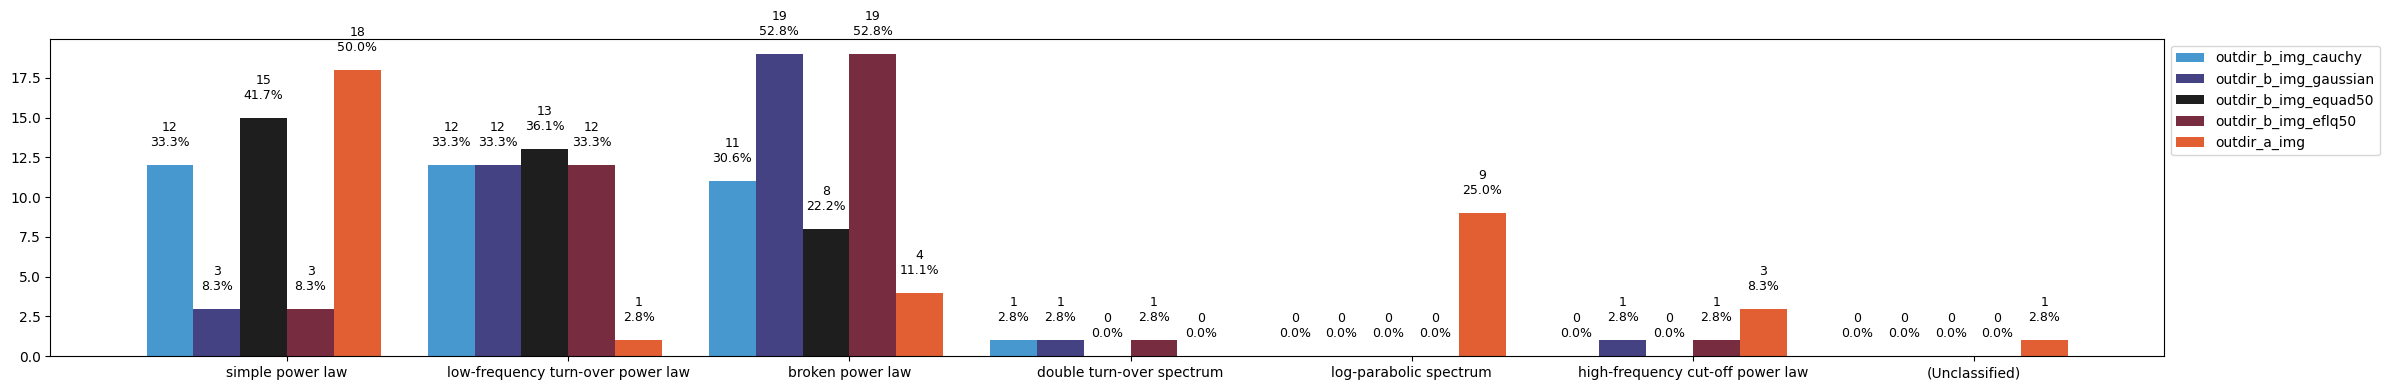

In [9]:
bar_chart(outdirs_2, 'bar_chart_2.png')

outdir_b_all_cauchy:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_gaussian:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_equad50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 868
outdir_b_all_eflq50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_a_all:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882


,Model,outdir_b_all_cauchy,outdir_b_all_gaussian,outdir_b_all_equad50,outdir_b_all_eflq50,outdir_a_all
0,broken power law,29 / 85 (34.1%),52 / 85 (61.2%),32 / 83 (38.6%),49 / 85 (57.6%),25 / 85 (29.4%)
1,simple power law,29 / 85 (34.1%),17 / 85 (20.0%),23 / 83 (27.7%),17 / 85 (20.0%),25 / 85 (29.4%)
2,low-frequency turn-over power law,21 / 85 (24.7%),13 / 85 (15.3%),21 / 83 (25.3%),14 / 85 (16.5%),1 / 85 (1.2%)
3,high-frequency cut-off power law,4 / 85 (4.7%),2 / 85 (2.4%),4 / 83 (4.8%),4 / 85 (4.7%),6 / 85 (7.1%)
4,log-parabolic spectrum,2 / 85 (2.4%),1 / 85 (1.2%),1 / 83 (1.2%),1 / 85 (1.2%),25 / 85 (29.4%)
5,double turn-over spectrum,0 / 85 (0.0%),0 / 85 (0.0%),0 / 83 (0.0%),0 / 85 (0.0%),1 / 85 (1.2%)
6,(Unclassified),0 / 85 (0.0%),0 / 85 (0.0%),2 / 83 (2.4%),0 / 85 (0.0%),2 / 85 (2.4%)


,outdir_b_all_cauchy,outdir_b_all_gaussian,outdir_b_all_equad50,outdir_b_all_eflq50
broken_power_law,27 / 85 (31.8%),52 / 85 (61.2%),28 / 81 (34.6%),52 / 85 (61.2%)
double_turn_over_spectrum,14 / 85 (16.5%),32 / 85 (37.6%),12 / 81 (14.8%),33 / 85 (38.8%)
high_frequency_cut_off_power_law,15 / 85 (17.6%),31 / 85 (36.5%),15 / 81 (18.5%),31 / 85 (36.5%)
log_parabolic_spectrum,16 / 85 (18.8%),43 / 85 (50.6%),21 / 81 (25.9%),43 / 85 (50.6%)
low_frequency_turn_over_power_law,22 / 85 (25.9%),40 / 85 (47.1%),24 / 81 (29.6%),40 / 85 (47.1%)
(Any ln BF > 3),29 / 85 (34.1%),52 / 85 (61.2%),31 / 81 (38.3%),52 / 85 (61.2%)
(All ln BF < -3),0 / 85 (0.0%),0 / 85 (0.0%),0 / 81 (0.0%),0 / 85 (0.0%)


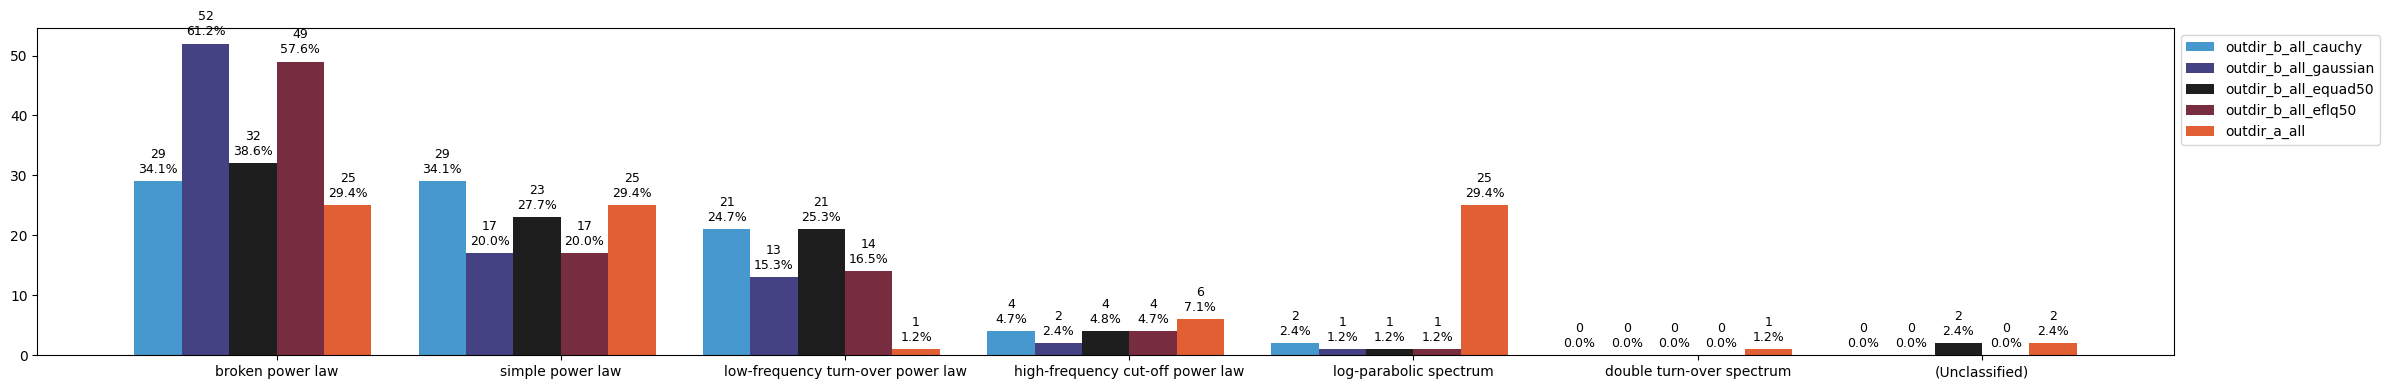

In [10]:
bar_chart(outdirs_1, 'bar_chart_3.png', msp=True)

outdir_b_all_cauchy:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_gaussian:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_b_all_equad50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 868
outdir_b_all_eflq50:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882
outdir_a_all:
 - Number of pulsars in the catalogue: 2300
 - Number of pulsars with at least 4, 5, 6 measurements: 1658, 1601, 1528
 - Number of pulsars reaching fitting requirements: 882


,Model,outdir_b_all_cauchy,outdir_b_all_gaussian,outdir_b_all_equad50,outdir_b_all_eflq50,outdir_a_all
0,broken power law,272 / 769 (35.4%),499 / 769 (64.9%),222 / 755 (29.4%),498 / 769 (64.8%),289 / 769 (37.6%)
1,simple power law,203 / 769 (26.4%),77 / 769 (10.0%),256 / 755 (33.9%),76 / 769 (9.9%),146 / 769 (19.0%)
2,low-frequency turn-over power law,187 / 769 (24.3%),78 / 769 (10.1%),186 / 755 (24.6%),78 / 769 (10.1%),60 / 769 (7.8%)
3,double turn-over spectrum,55 / 769 (7.2%),48 / 769 (6.2%),34 / 755 (4.5%),47 / 769 (6.1%),28 / 769 (3.6%)
4,high-frequency cut-off power law,26 / 769 (3.4%),31 / 769 (4.0%),22 / 755 (2.9%),33 / 769 (4.3%),81 / 769 (10.5%)
5,log-parabolic spectrum,25 / 769 (3.3%),23 / 769 (3.0%),27 / 755 (3.6%),24 / 769 (3.1%),157 / 769 (20.4%)
6,(Unclassified),1 / 769 (0.1%),13 / 769 (1.7%),8 / 755 (1.1%),13 / 769 (1.7%),8 / 769 (1.0%)


,outdir_b_all_cauchy,outdir_b_all_gaussian,outdir_b_all_equad50,outdir_b_all_eflq50
broken_power_law,293 / 768 (38.2%),578 / 756 (76.5%),202 / 747 (27.0%),577 / 756 (76.3%)
double_turn_over_spectrum,209 / 768 (27.2%),402 / 756 (53.2%),141 / 747 (18.9%),398 / 756 (52.6%)
high_frequency_cut_off_power_law,140 / 768 (18.2%),402 / 756 (53.2%),84 / 747 (11.2%),404 / 756 (53.4%)
log_parabolic_spectrum,211 / 768 (27.5%),483 / 756 (63.9%),162 / 747 (21.7%),481 / 756 (63.6%)
low_frequency_turn_over_power_law,259 / 768 (33.7%),434 / 756 (57.4%),199 / 747 (26.6%),433 / 756 (57.3%)
(Any ln BF > 3),326 / 768 (42.4%),601 / 756 (79.5%),231 / 747 (30.9%),600 / 756 (79.4%)
(All ln BF < -3),0 / 768 (0.0%),0 / 756 (0.0%),0 / 747 (0.0%),0 / 756 (0.0%)


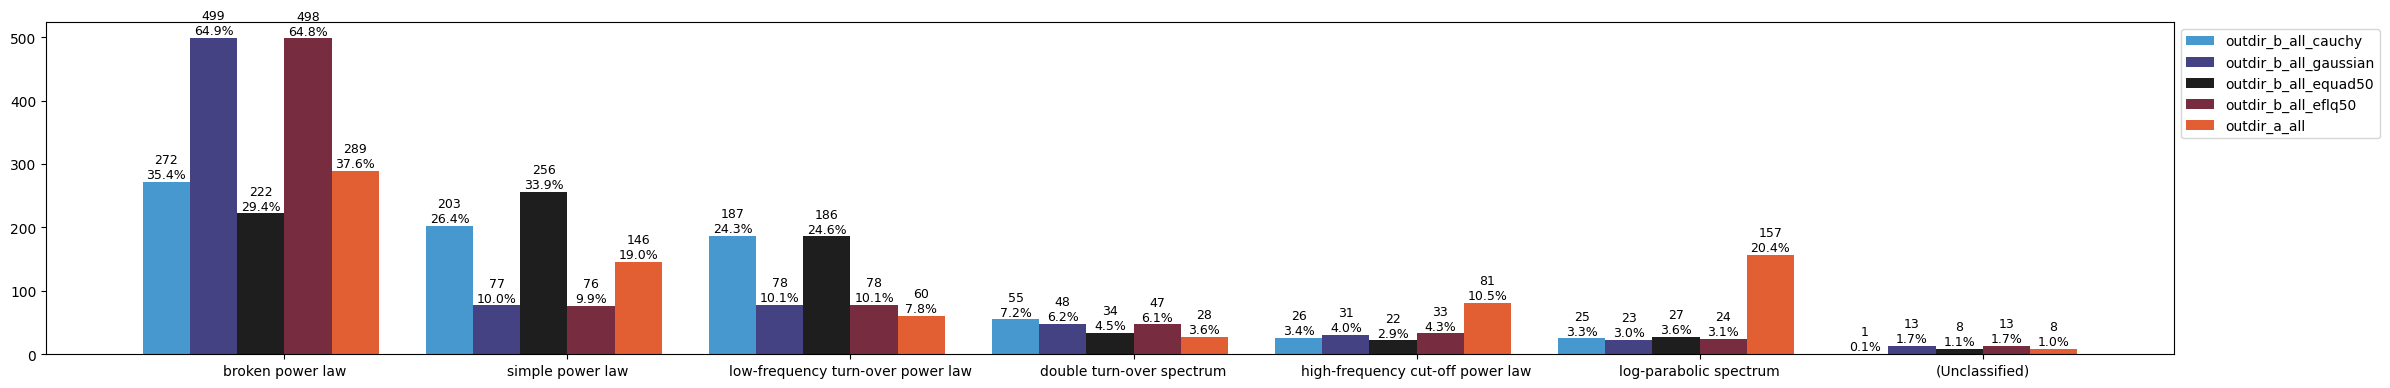

In [11]:
bar_chart(outdirs_1, 'bar_chart_4.png', ten_points=True)